In [0]:
!pip install git+https://github.com/tensorflow/privacy

  Cloning https://github.com/tensorflow/privacy to /tmp/pip-req-build-ek534jqi
  Running command git clone -q https://github.com/tensorflow/privacy /tmp/pip-req-build-ek534jqi
  Stored in directory: /tmp/pip-ephem-wheel-cache-25zhpzwb/wheels/8a/e4/14/41d16468ac11ec804bd21cfb75fc2e24f96b9e4c5af778f576
Successfully built privacy


In [0]:
#@test {"skip": true}

# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

!pip install --quiet tensorflow_federated
!pip install --quiet  tf-nightly
#!pip install tensorflow==2.0.0-alpha0

In [0]:
from __future__ import absolute_import, division, print_function

import collections
from privacy.optimizers import dp_optimizer
from privacy.optimizers.dp_optimizer import make_optimizer_class, DPAdamOptimizer
from six.moves import range
import numpy as np
import tensorflow as tf

import tensorflow_federated as tff

np.random.seed(0)

tf.compat.v1.enable_v2_behavior()

tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

In [0]:
#@test {"output": "ignore"}
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [0]:
len(emnist_train.client_ids)

3383

In [0]:
emnist_train.output_types, emnist_train.output_shapes

(OrderedDict([('label', tf.int32), ('pixels', tf.float32)]),
 OrderedDict([('label', TensorShape([])), ('pixels', TensorShape([28, 28]))]))

In [0]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

5

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


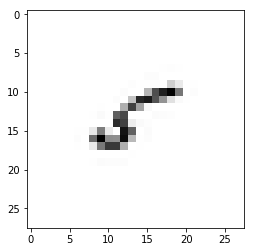

In [0]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid('off')
_ = plt.show()

In [0]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500


def preprocess(dataset):

  def element_fn(element):
    return collections.OrderedDict([
        ('x',tf.reshape(element['pixels'], [1,28,28,])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
      SHUFFLE_BUFFER).batch(BATCH_SIZE)

Let's verify this worked.

In [0]:
#@test {"output": "ignore"}
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

sample_batch

OrderedDict([('x', array([[[[1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       ...,
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.]]],
              
              
                     [[[1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       ...,
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.]]],
              
              
                     [[[1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       [1., 1., 1., ..., 1., 1., 1.],
                       ...,
                       [1., 1., 1., .

In [0]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

In [0]:
#@test {"output": "ignore"}
NUM_CLIENTS = 10

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
#print(sample_clients)

federated_train_data = make_federated_data(emnist_train, sample_clients)

sample_clients = emnist_test.client_ids[0:NUM_CLIENTS]
#print(sample_clients)
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_train_data), federated_train_data[0]

(10,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 1, 28, 28)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [0]:
print(iter(federated_test_data[1]).next()['y'])

tf.Tensor(
[[1]
 [1]
 [6]
 [2]
 [2]
 [3]
 [4]
 [2]
 [2]
 [7]
 [6]
 [7]
 [6]
 [6]
 [7]
 [1]
 [9]
 [1]
 [6]
 [1]], shape=(20, 1), dtype=int32)


In [0]:
def create_compiled_keras_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(input_shape=(1,28,28), filters=32, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Flatten(),
      #tf.keras.layers.Dense(
          #100, activation='relu',),
      #tf.keras.layers.Dense(
          #100, activation='relu',),
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax, kernel_initializer='zeros')])
  #dpopt = DPAdamOptimizer
  dpopt = dp_optimizer.DPGradientDescentGaussianOptimizer(
            l2_norm_clip=1.0,
            noise_multiplier=1.1,
            num_microbatches=256,
            learning_rate=.15,)
  #opt = tf.keras.optimizers.Adam
  #opt.compute_gradients = opt.get_gradients
  #opt = make_optimizer_class(opt)
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  #model.optimizer = model.optimizer.optimizer
 
  return model

def create_keras_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(input_shape=(1,28,28), filters=32, kernel_size=2, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      #tf.keras.layers.Dense(
          #100, activation='relu',),
      #tf.keras.layers.Dense(
          #100, activation='relu',),
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax, kernel_initializer='zeros')])
  return model
  
  '''  model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer = 'adam',
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])'''
  

In [0]:
#keras_model = create_compiled_keras_model()
def model_fn():
  keras_model = create_compiled_keras_model()
  return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [0]:
m = create_compiled_keras_model()
#m.optimizer.variables = m.optimizer.optimizer.variables
#m.optimizer.optimizer.variables
'''dpopt = dp_optimizer.DPGradientDescentGaussianOptimizer(
          l2_norm_clip=1.0,
          noise_multiplier=1.1,
          num_microbatches=256,
          learning_rate=.15,).variables'''

#m.optimizer = m.optimizer.optimizer
model_fn()

In [0]:
#@test {"output": "ignore"}
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

In [0]:
#@test {"output": "ignore"}
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<conv2d/kernel=float32[2,2,28,32],conv2d/bias=float32[32],dense/kernel=float32[896,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [0]:
state = iterative_process.initialize()

In [0]:
#@test {"timeout": 600, "output": "ignore"}
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.32314816,loss=2.0635908>


In [0]:
#@test {"skip": true}
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.5004115,loss=1.7964611>
round  3, metrics=<sparse_categorical_accuracy=0.713786,loss=1.1462393>
round  4, metrics=<sparse_categorical_accuracy=0.7941358,loss=0.78814197>
round  5, metrics=<sparse_categorical_accuracy=0.84537035,loss=0.5939867>
round  6, metrics=<sparse_categorical_accuracy=0.88868314,loss=0.43604073>
round  7, metrics=<sparse_categorical_accuracy=0.9099794,loss=0.3268376>
round  8, metrics=<sparse_categorical_accuracy=0.92314816,loss=0.28121787>
round  9, metrics=<sparse_categorical_accuracy=0.9272634,loss=0.25278515>
round 10, metrics=<sparse_categorical_accuracy=0.9314815,loss=0.23612824>


In [0]:
nmodel = create_compiled_keras_model()
tff.learning.assign_weights_to_keras_model(nmodel, state.model)


In [0]:
basemodel = create_compiled_keras_model()
for i in range(10):
  basemodel.fit(iter(federated_train_data[i]).next()['x'].numpy(),iter(federated_train_data[i]).next()['y'].numpy(),shuffle=True,epochs=10)

Train on 20 samples
Epoch 1/10
20/20 [==============================] - 0s 3ms/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1500
Epoch 2/10
20/20 [==============================] - 0s 292us/sample - loss: 2.3193 - sparse_categorical_accuracy: 0.4000
Epoch 3/10
20/20 [==============================] - 0s 197us/sample - loss: 1.9799 - sparse_categorical_accuracy: 0.2500
Epoch 4/10
20/20 [==============================] - 0s 253us/sample - loss: 2.0365 - sparse_categorical_accuracy: 0.1000
Epoch 5/10
20/20 [==============================] - 0s 136us/sample - loss: 1.8519 - sparse_categorical_accuracy: 0.4000
Epoch 6/10
20/20 [==============================] - 0s 204us/sample - loss: 1.8259 - sparse_categorical_accuracy: 0.2500
Epoch 7/10
20/20 [==============================] - 0s 173us/sample - loss: 1.7809 - sparse_categorical_accuracy: 0.2500
Epoch 8/10
20/20 [==============================] - 0s 115us/sample - loss: 1.7339 - sparse_categorical_accuracy: 0.2500
Epoch 9/10
20/

In [0]:
met = []
met2 = []
for i in range(10):
  met.append(nmodel.evaluate(iter(federated_test_data[i]).next()['x'].numpy(),iter(federated_test_data[i]).next()['y'].numpy()))
for i in range(10):
  met2.append(basemodel.evaluate(iter(federated_test_data[i]).next()['x'].numpy(),iter(federated_test_data[i]).next()['y'].numpy())) 

20/20 [==============================] - 0s 79us/sample - loss: 1.4971 - sparse_categorical_accuracy: 0.4000


In [0]:
met = np.array(met)
print(np.mean(met[:,1]))
met2 = np.array(met2)
print(np.mean(met2[:,1]))

0.8050000011920929
0.49500000178813935


In [0]:
nmodel.save('mymodel.h5')

In [0]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file('mymodel.h5')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()


In [0]:
open("model.tflite", "wb").write(tflite_quant_model)
from google.colab import files

files.download('model.tflite')

In [0]:

interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


tf.logging.set_verbosity(tf.logging.DEBUG)


In [0]:
i = 4
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = np.array([iter(federated_test_data[1]).next()['x'][i].numpy()], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])[0]
print(output_data)
result = np.where(output_data == np.amax(output_data))
print(result[0][0])
print(iter(federated_test_data[1]).next()['y'][i].numpy()[0])

[2.9535621e-02 5.8720782e-03 9.5464349e-01 6.5183340e-05 6.2618951e-06
 9.0620393e-05 4.5748260e-03 6.0315931e-04 4.6050004e-03 3.7405500e-06]
2
2


7   9


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


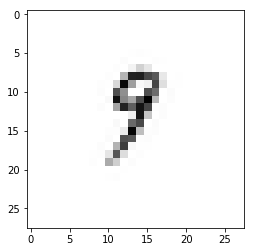

7   9


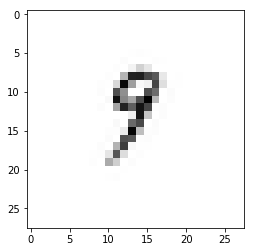

1   0


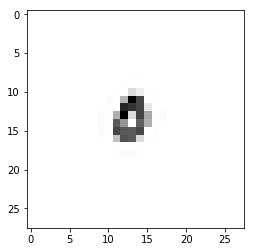

1   0


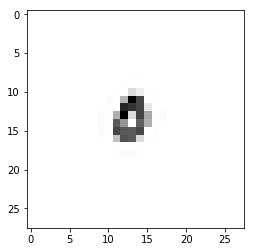

1   0


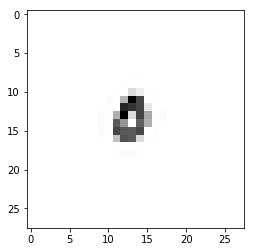

7   9


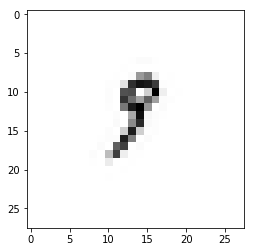

4   9


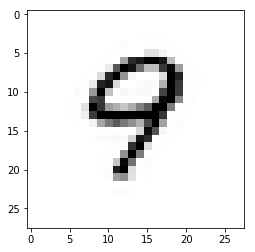

5   2


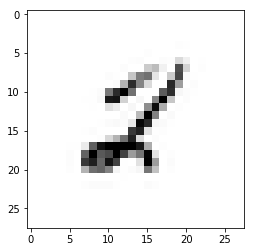

5   2


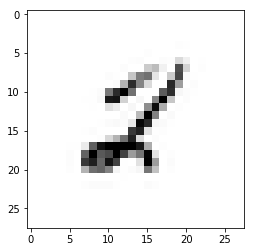

4   9


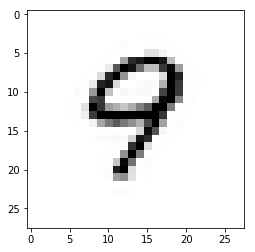

5   2


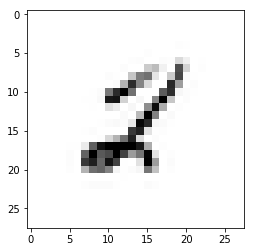

8   9


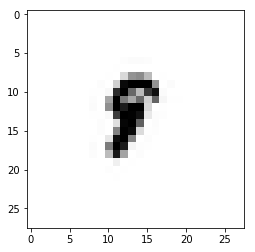

8   5


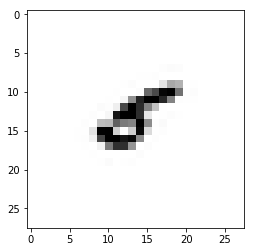

8   9


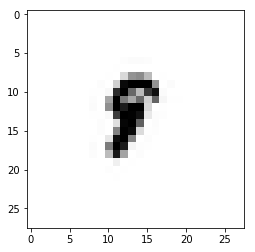

8   0


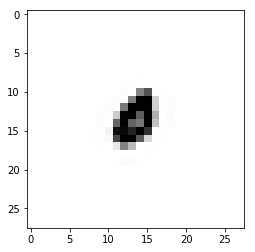

3   2


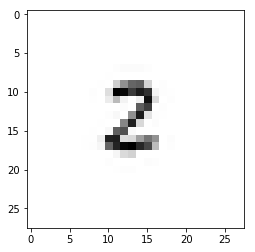

9   4


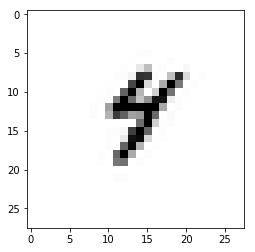

9   4


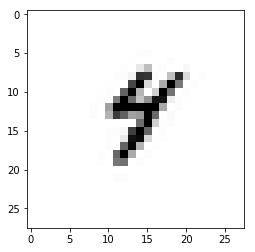

9   4


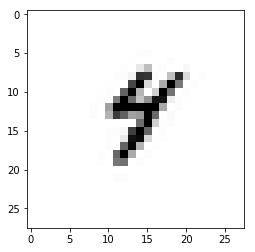

7   9


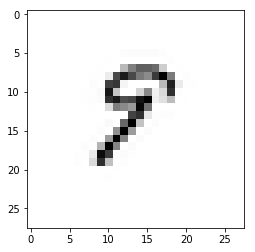

7   9


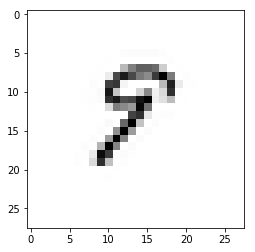

7   9


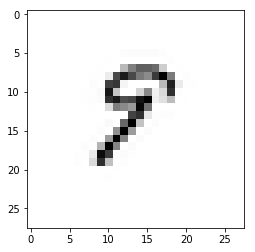

5   0


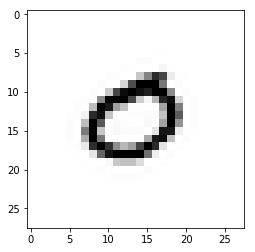

5   0


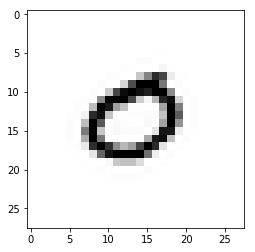

5   0


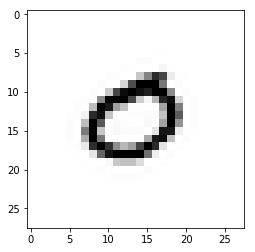

8   5


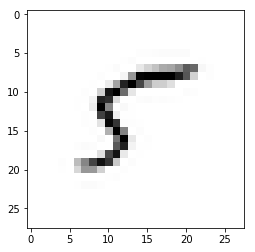

8   5


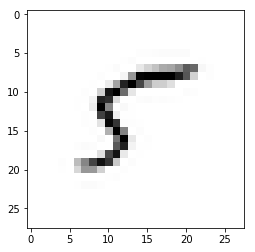

8   5


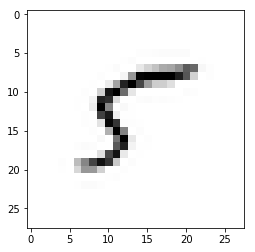

5   0


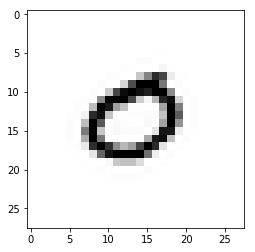

9   5


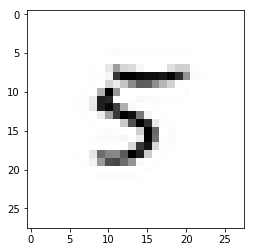

4   9


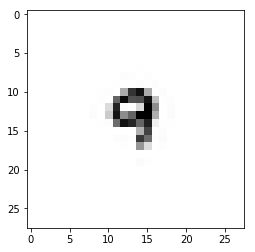

0   5


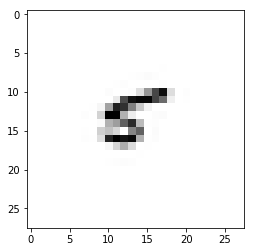

8   0


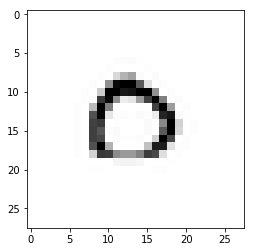

8   0


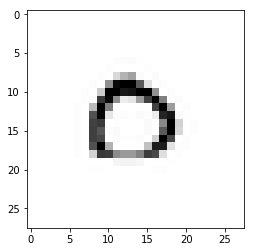

8   0


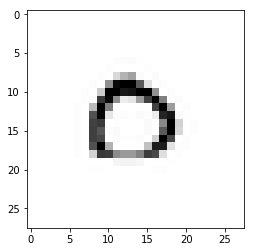

6   8


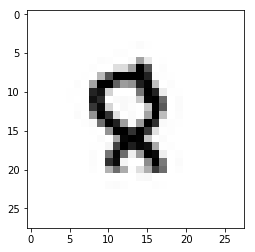

7   0


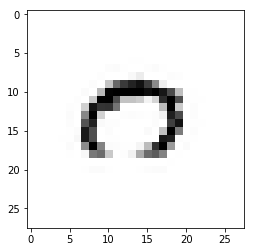

7   0


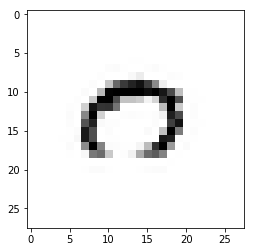

200 162 0.81


In [0]:
correct = 0
total = 0
for i in range(10):
  for j in range(20):
    total+=1
    input_shape = input_details[0]['shape']
    #input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = np.array([iter(federated_test_data[i]).next()['x'][j].numpy()], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    #print(output_data)
    result = np.where(output_data == np.amax(output_data))
    #print(result[0][0])
    #print(iter(federated_test_data[1]).next()['y'][i].numpy()[0])
    if(result[0][0] == iter(federated_test_data[i]).next()['y'][j].numpy()[0]):
      #print('yay')
      correct+=1
    else:
      print(result[0][0],' ',iter(federated_test_data[i]).next()['y'][j].numpy()[0])
      plt.imshow(iter(federated_test_data[i]).next()['x'][j].numpy()[0], cmap='gray', aspect='equal')
      plt.grid('off')
      _ = plt.show()
      

print(total, correct, correct/total)    

In [0]:
#iter(federated_test_data[1]).next()['x'][1].numpy()
#input_shape
#input_data.numpy()